# $B_z$ extraction is simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/")
import CommonUtils as cu

### Define constants and starting fit parameters

In [2]:
bin_w = 150*1e-3 # 150 ns 
min_x = 0 # us  #TODO 30 for data 
max_x = 500 # us 
p_min = 1800 # MeV 
print("Starting and end times [us]:", min_x, max_x)
print("P cut [MeV]:", p_min)

omega_a = 1.44 # MHz (magic)
gm2_f = 0.23 # MHz
g2period = 2*np.pi / omega_a   # 4.36 us 

phase=6.240
print("Using derived phase of [rad]", phase)

gm2_asym = 0.45 
ang_amp = 1.0
cos_amp = 1. / np.sqrt(2)
sin_amp = np.sqrt(1 - np.power(cos_amp, 2))
p0_ver=(ang_amp, cos_amp, omega_a, phase, sin_amp)

Starting and end times [us]: 0 500
P cut [MeV]: 1800
Using derived phase of [rad] 6.24


### Define fit functions

In [3]:
def f_vertical(t, *pars):
    N=pars[0]
    A_w=pars[1]
    omega=pars[2]
    phi=pars[3]
    A_edm=pars[4]
    return N*( A_w*np.cos(omega*t+phi) + A_edm*np.sin(omega*t+phi))


### Load HDF5 data and apply time and momentum cuts

In [4]:
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )
mom_cut = (data['trackMomentum'] > p_min) # MeV  
time_cut = (data['trackT0'] > min_x) # MeV  
data=data[mom_cut & time_cut]

#define station cuts to loop over
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

### Resolve variables

In [5]:
p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y = np.arctan2(py, p)
data['mod_times']=mod_times
data['theta_y']=theta_y
N=data.shape[0] 
data

,trackT0,station,trackMomentum,trackMomentumY,mod_times,theta_y
2,80.277852,18,2544.615967,-59.835049,1.738035,-0.023510
3,42.755086,0,2182.920654,15.766864,3.485178,0.007223
6,10.879105,12,2120.369385,-8.798045,2.152459,-0.004149
18,11.418941,0,2252.512695,1.755878,2.692295,0.000780
20,204.562281,18,2131.132812,-22.711870,3.849417,-0.010657
...,...,...,...,...,...,...
5483776,70.492133,18,2016.368164,17.139523,0.678963,0.008500
5483788,33.120555,12,2171.714844,12.780183,2.577293,0.005885
5483789,82.543117,12,1940.134521,43.934719,4.003301,0.022641
5483793,21.286004,18,1840.056641,-38.210846,3.832711,-0.020763


### Digitise data

In [14]:
count_binw=0.01 # us 
count_xmin=0
count_xmax=g2period
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, count_binw, (count_xmin, count_xmax) )
y_err = np.sqrt(freq)

### Plot counts vs. mod time and fit

Params: [ 3.198e+03 -3.488e+09 -3.871e-01  1.417e+00  6.423e+00]
Errors: [8.024e+00 1.089e+15 2.341e-03 7.834e-03 1.711e-02]
𝝌2/dof=2.01


Text(0.8, 0.7, 'N=$1.4\\cdot10^{6}$')

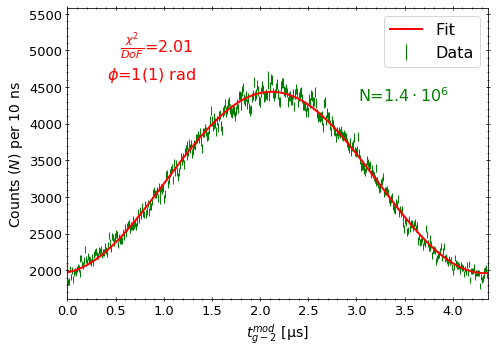

In [36]:
x,y,y_e = bin_c, freq, y_err
p0=[1e3, 1e4, -0.4, 1.44, 6.24]
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_function, p0)

fig, ax = cu.plot(bin_c, freq, y_err=y_err, error=True, elw=1, label="Data (sim.)",
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", ylabel=r"Counts ($N$) per "+str(int(count_binw*1e3))+" ns")
ax.plot(bin_c, cu.unblinded_wiggle_function(bin_c, *par), color="red", 
        label=r'Fit: ', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(np.amin(freq)*0.9, np.amax(freq)*1.2);
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_par(leg_fit, [r"$\phi$"], [1], [1], ["rad"])
leg_data="N="+cu.sci_notation(N)
font_size=16
ax.legend(fontsize=font_size)
cu.textL(ax, 0.2, 0.8, leg_fit, color="r", font_size=font_size)
cu.textL(ax, 0.8, 0.7, leg_data, font_size=font_size)



### Profile the $\langle\theta_y\rangle$, fit and plot

In [10]:
df_binned =cu.Profile(mod_times, theta_y, None, nbins=15, xmin=np.min(mod_times), xmax=np.max(mod_times), mean=True, only_binned=True)
x=df_binned['bincenters']
y=df_binned['ymean']*1e3
y_e=df_binned['yerr']*1e3
x_e=df_binned['xerr']
df_binned

,index,bincenters,ymean,xerr,yerr
0,1,0.145448,0.000025,0.145444,0.000055
1,2,0.436336,0.000178,0.145444,0.000051
2,3,0.727223,0.000108,0.145444,0.000046
3,4,1.018111,0.000182,0.145444,0.000042
4,5,1.308999,0.000165,0.145444,0.000038
5,6,1.599887,0.000219,0.145444,0.000035
6,7,1.890775,0.000157,0.145444,0.000035
7,8,2.181662,0.000066,0.145444,0.000035
8,9,2.472550,0.000022,0.145444,0.000036
9,10,2.763438,-0.000005,0.145444,0.000037


In [11]:
# Levenberg-Marquardt algorithm as implemented in MINPACK
par, pcov = optimize.curve_fit(cu.thetaY_unblinded_phase, x, y, sigma=y_e, p0=[0.00, 0.14, 0.02, 1.41], absolute_sigma=False, method='lm')
par_e = np.sqrt(np.diag(pcov))
print("Params:", par)
print("Errors:", par_e)
chi2_ndf, chi2, ndf=cu.chi2_ndf(x, y, y_e, cu.thetaY_unblinded_phase, par)
print( r"Fit $\frac{\chi^2}{\rm{DoF}}$="+str(round(chi2_ndf,2)) )

Params: [-0.02482847  0.13836955  0.05216744  1.4113823 ]
Errors: [0.03468432 0.01603244 0.01222005 0.11066867]
Fit $\frac{\chi^2}{\rm{DoF}}$=1.04


  $\frac{\chi^2}{DoF}$=1.04

$ A_{B_z}$=-0.02(3) mrad
$ A_{\rm{EDM}}$=+0.14(2) mrad
c=+0.05(1) mrad
$\omega$=+1.41(11) MhZ



TypeError: textL() got an unexpected keyword argument 'fontsize'

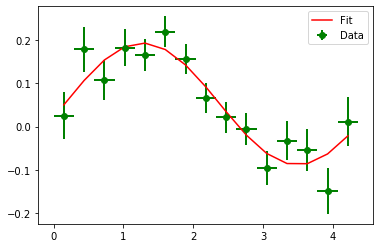

In [12]:
fix, ax = cu.profile_plot(x,y,x_e,y_e,cu.thetaY_unblinded_phase, par, par_e, chi2_ndf, N)